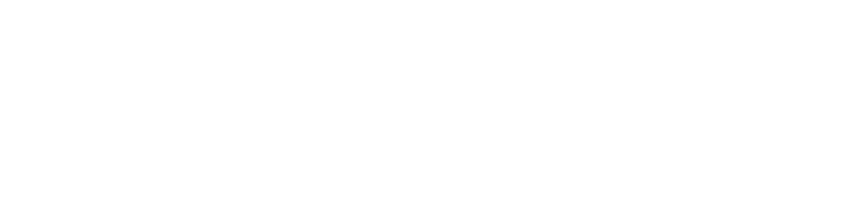

# Train token-classification model

Token classification assigns a label to individual tokens in a sentence. One of the most common token classification tasks is `Named Entity Recognition (NER)`. NER attempts to find a label for each entity in a sentence, such as a person, location, or organization.


This notebook is intended to train `token-classification` models based on `distilbert base uncased` model. To do so we are using [Transformers 🤗🤗](https://huggingface.co/docs/transformers/index).


### Install Required libs && set env variables 📥📥

In [ ]:
# Step 1: Install necessary libraries
!pip install datasets evaluate transformers[sentencepiece] -q
!pip install accelerate seqeval mlflow optimum[openvino,nncf] -q

In [ ]:
import mlflow

## Set mlflow tracking URI
mlflow.set_tracking_uri(os.environ.get("MLFLOW_TRACKING_URI"))

## Load the bucket and file path
bucket_name =  os.environ['bucket']

## AWS_ACCESS_KEY_ID & AWS_SECRET_ACCESS_KEY should be set as Env variables
key_id = os.environ.get('S3_ACCESS_KEY_ID')
secret_key = os.environ.get('S3_SECRET_ACCESS_KEY')

### Assign a name & version to your deployment 🧙‍♂️🧙‍♂️

This process is crucial mainly because a `token-classification` model can be intended for a huge amount of approaches

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Creating a box layout for better widget organization
box_layout = widgets.Layout(display='flex',
                            flex_flow='row',
                            justify_content='space-between',
                            width='50%')

# Text input widget
model_name_text = widgets.Text(
    description='Model Name:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(flex='2 1 auto', width='auto')
)

version_model_text = widgets.Text(
    description='Version:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(flex='2 1 auto', width='auto')
)

# Button widget
button_model = widgets.Button(description="Save",
                        button_style='primary',  # Apply a Bootstrap theme
                        layout=widgets.Layout(flex='1 1 auto', width='auto'))

button_version = widgets.Button(description="Save",
                        button_style='primary',  # Apply a Bootstrap theme
                        layout=widgets.Layout(flex='1 1 auto', width='auto'))

# Function to handle button click
def on_button_clicked(b):
    print("Saved text: ", text.value)

# Linking the button click event to the function
button_model.on_click(on_button_clicked)
button_version.on_click(on_button_clicked)

# Using a VBox for vertical stacking of widgets
widget_box_model = widgets.VBox([model_name_text, button_model], layout=box_layout)
widget_version = widgets.VBox([version_model_text, button_version], layout=box_layout)

# Displaying the widgets
display(widget_box_model)
display(widget_version)


In [ ]:
model_name=model_name_text.value
version_model= version_model_text.value
print(f"Your model is going to be saved with name `{model_name}` & version `{version_model}`")
print(f"\n Under directory models/openvino/token-classification/{model_name}/{version_model}")
model_path_s3=f"models/openvino/token-classification/{model_name}/{version_model}"

## Working with our dataset 📜📜📜


1) Assign a float to the `train`,`valid` & `test` size of datasets
2) Load dataframe in memory
3) Make sure all columns are correctly set


In [ ]:
train_size=0.7
valid_size= 0.1
test_size = 0.2
print(f"Dataframe is going to be splitted into {train_size*100:.0f}%, {valid_size*100:.0f}% valid size and {test_size*100:.0f}% data to test")

In [ ]:
## Loads datasets from previous notebook
import pandas as pd
import os
import json
import ast
from datasets import Dataset, Features, Sequence, ClassLabel, Value

labeled_dataset = "dataset.csv"

# Read json files label2id &  id2label
# Opening JSON file
file_label2id = open('tags.json')
file_id2label = open('tags2id.json')

tags = json.load(file_label2id)
tags2id=json.load(file_id2label)


print(f"\n{tags.get('tags')}")
print(f"{tags2id}")
os.remove("tags.json")
os.remove("tags2id.json")


# Assuming the file is in the current working directory
df = pd.read_csv(labeled_dataset)


# Assuming 'ner_tags' and 'tokens' are stored as strings representing lists
# Convert 'ner_tags' and 'tokens' from string representations of lists back to actual lists
df['ner_tags'] = df['ner_tags'].apply(ast.literal_eval)
df['tokens'] = df['tokens'].apply(ast.literal_eval)



# Define your dataset's features, particularly the ner_tags as a sequence of ClassLabel
features = Features({
    '_id': Value('int64'),  # or whatever your ID's type is
    'tokens': Sequence(Value('string')),
    'ner_tags': Sequence(ClassLabel(names=tags.get("tags")))
})


df.head()

In [ ]:
# Function to convert ner_tags from strings to their corresponding IDs
def tags_to_ids(tags):
    # Ensure tag is a string, matching the format of keys in tags2id
    return [tags2id[str(tag)] for tag in tags]

df['ner_tags'] = df['ner_tags'].apply(tags_to_ids)

In [ ]:
from datasets import DatasetDict
df_dataset = Dataset.from_pandas(df,features=features)

# Calculate the split sizes for validation and test sets as a proportion of the remainder
remainder_size = 1.0 - train_size
proportion_valid = valid_size / remainder_size
proportion_test = test_size / remainder_size

# Split the dataset into training and the remainder (test + validation)
train_dataset, test_valid_dataset = df_dataset.train_test_split(test_size=remainder_size).values()

# Now split the remainder into validation and test datasets
valid_dataset, test_dataset = test_valid_dataset.train_test_split(test_size=proportion_test).values()


# Creating the DatasetDict with the splits
dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

In [ ]:
dataset

In [ ]:
words = dataset["train"][1]["tokens"]
labels = dataset["train"][1]["ner_tags"]
line1 = ""
line2 = ""
tags=tags.get("tags")
for word, label in zip(words, labels):
    full_label = tags[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

#### Working with foundational model tokenizer 🎩🎩

Here we make sure to truncate sequences to be no longer than foundational model maximum input length

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer.is_fast

In [ ]:
inputs = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True)

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = dataset["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# apply the preprocessing function over the entire dataset
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

## Computing metrics for `MlFlow`  📈📈

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
## Metrics
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
import numpy as np
example = dataset["train"][0]
labels = [tags[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [tags[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tags[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
id2label = {i: label for i, label in enumerate(tags)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
## Mapping ids -> labels
id2label
label2id

In [ ]:
# Creating a box layout for better widget organization
box_layout = widgets.Layout(display='flex',
                            flex_flow='row',
                            justify_content='space-between',
                            width='50%')

# Text input widget
run_name_text = widgets.Text(
    description='Run Name:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(flex='2 1 auto', width='auto')
)

# Button widget
button = widgets.Button(description="Save",
                        button_style='primary',  # Apply a Bootstrap theme
                        layout=widgets.Layout(flex='1 1 auto', width='auto'))

# Function to handle button click
def on_button_clicked(b):
    print("Saved text: ", text.value)

# Linking the button click event to the function
button.on_click(on_button_clicked)

# Using a VBox for vertical stacking of widgets
widget_box = widgets.VBox([run_name_text, button], layout=box_layout)

# Displaying the widgets
display(widget_box)

In [ ]:
mlflow.set_experiment(model_name)

## Training with `Transformers` & `PyTorch`

1) Retrieve model from hub
2) Assign the configuration specifically amount of labels and ids

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(tags),
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
os.environ["MFLOW_EXPERIMENT_NAME"]=model_name
os.environ["MLFLOW_FLATTEN_PARAMS"]="1"

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    hub_model_id=model_name,
    output_dir=run_name_text.value,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
mlflow.end_run()

### OpenVino 🍷🍷

After successfull model training we are going to save the model as a `OpenVino` format so Openshift AI can serve it into a inference endpoint

In [ ]:
## Save pytorch 
trainer.save_model(model_name)

In [ ]:
from optimum.intel import OVModelForTokenClassification

ov_model= OVModelForTokenClassification.from_pretrained(model_name,export=True)
ov_model.save_pretrained(f"{model_name}_openvino")

## Model upload

1) We have correctly trained our model
2) Model was correctly parsed to `OpenVino` format

In this part we upload our model to S3 Provider so OpenshiftAI takes the binary and serves it


In [ ]:
import boto3
from datetime import datetime


session = boto3.session.Session()
s3_client = session.client('s3',
                        region_name='nyc3',
                        endpoint_url='https://nyc3.digitaloceanspaces.com',
                        aws_access_key_id=key_id,
                        aws_secret_access_key=secret_key)

def uploadModel(path):
     for root,dirs,files in os.walk(path):
            for file in files:
                s3_client.upload_file(os.path.join(root,file),bucket_name,f"models/openvino/token-classification/{model_name}/{version_model}/{file}")

In [ ]:
#Upload ov binary to S3 & mlflow run
uploadModel(f"{model_name}_openvino")

In [ ]:
## Delete directories in Jupyter Notebook
import shutil

# Remove the local model directory
shutil.rmtree(model_name)
os.remove(labeled_dataset)
shutil.rmtree(run_name_text.value)
shutil.rmtree(f"{model_name}_openvino")